# Data Science Fundamentals 5

Basic introduction on how to perform typical machine learning tasks with Python.

Prepared by Mykhailo Vladymyrov & Aris Marcolongo,
Science IT Support, University Of Bern, 2020

This work is licensed under <a href="https://creativecommons.org/share-your-work/public-domain/cc0/">CC0</a>.

# Solutions to Part 2.

In [2]:
from sklearn import tree
from sklearn import ensemble

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from matplotlib import  pyplot as plt
from time import time as timer
from imageio import imread
import pandas as pd
import numpy as np
import os

from sklearn.manifold import TSNE
import umap

import tensorflow as tf

%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

In [3]:
if not os.path.exists('data'):
    path = os.path.abspath('.')+'/colab_material.tgz'
    tf.keras.utils.get_file(path, 'https://github.com/neworldemancer/DSF5/raw/master/colab_material.tgz')
    !tar -xvzf colab_material.tgz > /dev/null 2>&1

188416/184367 [==============================] - 0s 0us/step


In [4]:
from utils.routines import *

# Datasets

In this course we will use several synthetic and real-world datasets to ilustrate the behavior of the models and excercise our skills.

## 1. House prices

Subset of the the hous pricess kaggle dataset: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [5]:
def house_prices_dataset(return_df=False, price_max=400000, area_max=40000):
  path = 'data/AmesHousing.csv'

  df = pd.read_csv(path, na_values=('NaN', ''), keep_default_na=False)
  
  rename_dict = {k:k.replace(' ', '').replace('/', '') for k in df.keys()}
  df.rename(columns=rename_dict, inplace=True)
  
  useful_fields = ['LotArea',
                  'Utilities', 'OverallQual', 'OverallCond',
                  'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond',
                  'HeatingQC', 'CentralAir', 'Electrical',
                  '1stFlrSF', '2ndFlrSF','GrLivArea',
                  'FullBath', 'HalfBath',
                  'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
                  'Functional','PoolArea',
                  'YrSold', 'MoSold'
                  ]
  target_field = 'SalePrice'

  df.dropna(axis=0, subset=useful_fields+[target_field], inplace=True)

  cleanup_nums = {'Street':      {'Grvl': 0, 'Pave': 1},
                  'LotFrontage': {'NA':0},
                  'Alley':       {'NA':0, 'Grvl': 1, 'Pave': 2},
                  'LotShape':    {'IR3':0, 'IR2': 1, 'IR1': 2, 'Reg':3},
                  'Utilities':   {'ELO':0, 'NoSeWa': 1, 'NoSewr': 2, 'AllPub': 3},
                  'LandSlope':   {'Sev':0, 'Mod': 1, 'Gtl': 3},
                  'ExterQual':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'ExterCond':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'BsmtQual':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtCond':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtExposure':{'NA':0, 'No':1, 'Mn': 2, 'Av': 3, 'Gd': 4},
                  'BsmtFinType1':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'BsmtFinType2':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'HeatingQC':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'CentralAir':  {'N':0, 'Y': 1},
                  'Electrical':  {'':0, 'NA':0, 'Mix':1, 'FuseP':2, 'FuseF': 3, 'FuseA': 4, 'SBrkr': 5},
                  'KitchenQual': {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Functional':  {'Sal':0, 'Sev':1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2':5, 'Min1':6, 'Typ':7},
                  'FireplaceQu': {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'PoolQC':      {'NA':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Fence':       {'NA':0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv':4},
                  }

  df_X = df[useful_fields].copy()                              
  df_X.replace(cleanup_nums, inplace=True)  # convert continous categorial variables to numerical
  df_Y = df[target_field].copy()

  x = df_X.to_numpy().astype(np.float32)
  y = df_Y.to_numpy().astype(np.float32)

  if price_max>0:
    idxs = y<price_max
    x = x[idxs]
    y = y[idxs]

  if area_max>0:
    idxs = x[:,0]<area_max
    x = x[idxs]
    y = y[idxs]

  return (x, y, df) if return_df else (x,y)

In [6]:
def house_prices_dataset_normed():
    x, y = house_prices_dataset(return_df=False, price_max=-1, area_max=-1)
    
    scaler=StandardScaler()
    features_scaled=scaler.fit_transform(x)
    
    return features_scaled

## 2. Fashion MNIST

`Fashion-MNIST` is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. (from https://github.com/zalandoresearch/fashion-mnist)

In [7]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


Let's chech few samples:

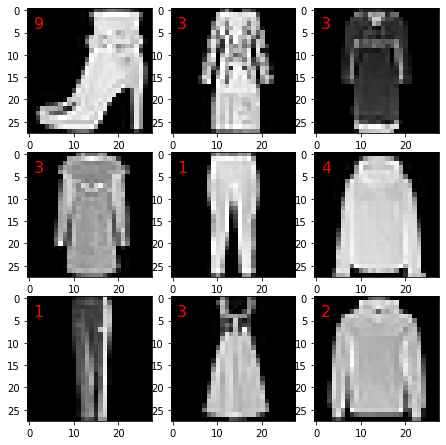

In [8]:
n = 3
fig, ax = plt.subplots(n, n, figsize=(2*n, 2*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
for axi, im_idx in zip(ax, np.random.choice(len(train_images), n**2)):
  im = train_images[im_idx]
  im_class = train_labels[im_idx]
  axi.imshow(im, cmap='gray')
  axi.text(1, 4, f'{im_class}', color='r', size=16)
plt.tight_layout(0,0,0)

Each training and test example is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

# EXERCISE 1 : Random forest classifier for FMNIST


In [9]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

n = len(train_labels)
x_train = train_images.reshape((n, -1))
y_train = train_labels

n_test = len(test_labels)
x_test = test_images.reshape((n_test, -1))
y_test = test_labels

In [10]:
# 1. Create classifier. As the number of features is big, use bigger tree depth 
# (max_depth parameter). in the same time to reduce variance, one should limit the
# total number of tree leafes. (max_leaf_nodes parameter)
# Try different number of estimators (n_estimators)

n_est = 20

dtc = ensemble.RandomForestClassifier(max_depth=700, n_estimators=n_est, max_leaf_nodes=500)

# 2. fit the model
t1 = timer()
dtc.fit(x_train, y_train)
t2 = timer()
print ('training time: %.1fs'%(t2-t1))

# 3. Inspect training and test accuracy
print("training score : %.3f (n_est=%d)" % (dtc.score(x_train, y_train), n_est))
print("test score : %.3f (n_est=%d)" % (dtc.score(x_test, y_test), n_est))


training time: 12.7s
training score : 0.893 (n_est=20)
test score : 0.854 (n_est=20)


# EXERCISE 2 : PCA with a non-linear data-set

We have  30 samples of dimension  2
Explained variance ratio:  [0.57388642 0.42611358]


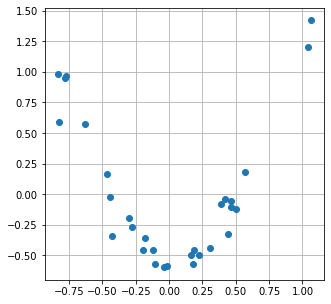

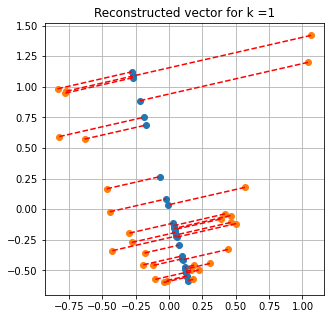

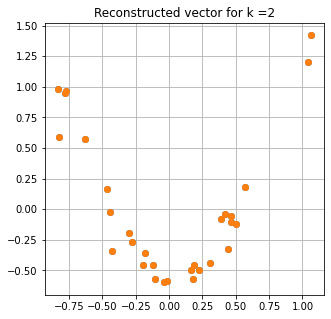

In [11]:
# 1. Load the data using the function load_ex1_data_pca() , check the dimensionality of the data and plot them.
# Solution:

data = load_ex1_data_pca()

n_samples,n_dim=data.shape

print('We have ',n_samples, 'samples of dimension ', n_dim)

plt.figure(figsize=((5,5)))
plt.grid()
plt.plot(data[:,0],data[:,1],'o')

# 2. Define a PCA object and perform the PCA fitting.
pca=PCA()
pca.fit(data)

# 3. Check the explained variance ratio and select best number of components.

print('Explained variance ratio: ' ,pca.explained_variance_ratio_)

# 4. Plot the reconstructed vectors for different values of k.

scores=pca.transform(data)
for k in range(1,3):
    res=np.dot(scores[:,:k], pca.components_[:k,:]) 

    plt.figure(figsize=((5,5)))
    plt.title('Reconstructed vector for k ='+ str(k))
    plt.plot(res[:,0],res[:,1],'o')
    plt.plot(data[:,0],data[:,1],'o')

    for a,b,c,d in zip(data[:,0],data[:,1],res[:,0],res[:,1]) :
        plt.plot([a,c],[b,d],'-', linestyle = '--', color='red')

    plt.grid()
    
# Message: if the manyfold is non-linear one is forced to use a high number of principal components. 
# For example, in the parabola example the projection for k=1 looks bad. But using too many principal components 
# the reconstructed vectors are almost equal to the original ones (for k=2 we get exact reconstruction in our example ) 
# and the advanteges of dimensionality reduction are lost. This is a general pattern.

# EXERCISE 3 : Find the hidden drawing.

We have  961 samples of dimension  10
Explained variance ratio:  [0.79700994 0.15407412 0.00688753 0.00667879 0.00652795 0.00605738
 0.00596107 0.00576693 0.00561825 0.00541804]


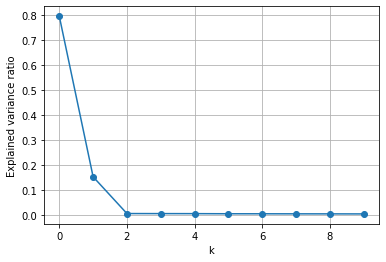

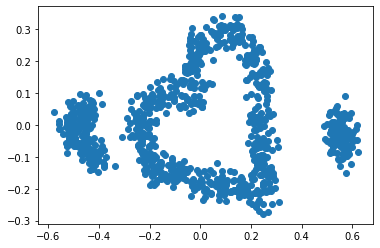

In [12]:
# 1. Load the data using the function load_ex2_data_pca(seed=1235) , check the dimensionality of the data and plot them.

data= load_ex2_data_pca(seed=1235)
n_samples,n_dim=data.shape
print('We have ',n_samples, 'samples of dimension ', n_dim)

# 2. Define a PCA object and perform the PCA fitting.
pca=PCA()
pca.fit(data)

# 3. Check the explained variance ratio and select best number of components.
plt.figure()
print('Explained variance ratio: ' ,pca.explained_variance_ratio_)
plt.plot(pca.explained_variance_ratio_,'-o')
plt.xlabel('k')
plt.ylabel('Explained variance ratio')
plt.grid()

# 4. Plot the reconstructed vectors for the best value of k.
plt.figure()
k=2
data_transformed=pca.transform(data)
plt.plot(data_transformed[:,0],data_transformed[:,1],'o')

# **Message:** Sometimes the data hides simple patterns in high dimensional datasets. 
# PCA can be very useful in identifying these patterns.